In [26]:
import csv
import pandas as pd
import numpy as np
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib import cm
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
min_max_scaler = preprocessing.MinMaxScaler()

import pyLDAvis
import pyLDAvis.gensim

In [189]:
 range(2, 2, 1)

range(2, 2)

In [2]:
features = pd.read_csv("ORs_genomicFeatures_mmusGRCm38.99.csv", index_col = [4])
features = features.iloc[:,1:]
features.head()

,Gene.stable.ID,Gene.start..bp.,Gene.end..bp.,Chromosome.scaffold.name,length,gen_clust,Length.of.cluster,X..ORs,X..Greek.Islands,Greek.Islands,...,mOSN.Ebf.,mOSN.Lhx2.,mOSN.H3K9me3.,Within.500bp.of.OR.TSS.,islandChr,islandStart,islandEnd,islandLength,dist2genClustStart,dist2genClustEnd
Gene.name,,,,,,,,,,,,,,,,,,,,,
Olfr12,ENSMUSG00000061616,92617788,92623412,1,5624,OR-Cluster-1,163384.0,8.0,1.0,Rhodes,...,Yes,Yes,Yes,No,1,92545930.0,92546383.0,453.0,144029.0,13731.0
Olfr1404,ENSMUSG00000049456,173212392,173218583,1,6191,OR-Cluster-2,379404.0,7.0,3.0,Kea; Kythnos; Serifos,...,Yes,Yes,Yes,Yes,1,173212162.0,173212558.0,396.0,317337.0,55876.0
Olfr1406,ENSMUSG00000058981,173181853,173190640,1,8787,OR-Cluster-2,379404.0,7.0,3.0,Kea; Kythnos; Serifos,...,Yes,Yes,Yes,Yes,1,173190529.0,173190944.0,415.0,286798.0,83819.0
Olfr1407-ps1,ENSMUSG00000066680,173149171,173150371,1,1200,OR-Cluster-2,379404.0,7.0,3.0,Kea; Kythnos; Serifos,...,Yes,Yes,Yes,Yes,1,173190529.0,173190944.0,415.0,254116.0,124088.0
Olfr1408,ENSMUSG00000062527,173128049,173137374,1,9325,OR-Cluster-2,379404.0,7.0,3.0,Kea; Kythnos; Serifos,...,Yes,Yes,Yes,Yes,1,173190529.0,173190944.0,415.0,232994.0,137085.0


In [3]:
features.columns
#len(features.index)

Index(['Gene.stable.ID', 'Gene.start..bp.', 'Gene.end..bp.',
       'Chromosome.scaffold.name', 'length', 'gen_clust', 'Length.of.cluster',
       'X..ORs', 'X..Greek.Islands', 'Greek.Islands',
       'Greek.Island.composite.score', 'chromosome', 'genClustStart',
       'genClustEnd', 'closestIsland', 'dist2ClosestIsland', 'mOSN.Ebf.',
       'mOSN.Lhx2.', 'mOSN.H3K9me3.', 'Within.500bp.of.OR.TSS.', 'islandChr',
       'islandStart', 'islandEnd', 'islandLength', 'dist2genClustStart',
       'dist2genClustEnd'],
      dtype='object')

In [108]:
np.unique(features['X..Greek.Islands'])

array([ 0.,  1.,  2.,  3., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [110]:
lengths = np.unique(features['Length.of.cluster'])
bin_lengths = int(np.median(lengths[~np.isnan(lengths)]/3))
clust_length_labels = ['XS', 'S', 'M', 'L', 'XL', 'XXL']

def clust_length(df, bin):
    bins = []
    clust = np.ones([len(clust_length_labels), len(df.index)])
    
    for i in range(len(clust_length_labels)):
        bins.append(bin*i)
    partitions = np.digitize(df['Length.of.cluster'].values,bins)
    #print(partitions)
      
    for i in range(len(clust_length_labels)):
        #print(i)
        for item in range(len(partitions)):
         #   print(item)    
            if i+1 == partitions[item]:
                clust[i][item] = 1
            else:
                clust[i][item] = 0
    lengths_df = pd.DataFrame(clust, index = clust_length_labels)
    lengths_df.columns = df.index
            
    return lengths_df

In [126]:
ORs_in_clust = np.unique(features['X..ORs'])
bin_XOrs = int(np.median(ORs_in_clust[~np.isnan(ORs_in_clust)]/2))
clust_crowded_labels = ['crowded_0', 'crowded_1', 'crowded_2', 'crowded_3', 'crowded_4', 'crowded_5']

def ORs_in_clust(df, bin):
    bins = []
    clust = np.zeros([len(clust_crowded_labels), len(df.index)])
    
    for i in range(len(clust_crowded_labels)):
        bins.append(bin*i)
        
    #print(bins)
    partitions = np.digitize(df['X..ORs'].values,bins)
    
    #print(partitions)
      
    for i in range(len(clust_crowded_labels)):
        #print(i)
        for item in range(len(partitions)):
         #   print(item)    
            if i+1 == partitions[item]:
                #print(i)
                clust[i][item] = 1
                #print(clust)
            else:
                clust[i][item] = 0
    #print(clust)
    lengths_df = pd.DataFrame(clust, index = clust_crowded_labels)
    lengths_df.columns = df.index
            
    return lengths_df

In [150]:
count_islands = np.unique(features['X..Greek.Islands'])
bin_islands = len(count_islands[~np.isnan(count_islands)])/4
clust_islands_labels = ['X_1', 'X_2', 'X_3', 'X_4']

def count_islands(df, bin):
    bins = []
    clust = np.ones([len(clust_islands_labels), len(df.index)])
    
    for i in range(len(clust_islands_labels)):
        bins.append(bin*i)
    partitions = np.digitize(df['X..Greek.Islands'].values,bins)
    #print(partitions)
      
    for i in range(len(clust_island_labels)):
        #print(i)
        for item in range(len(partitions)):
         #   print(item)    
            if i+1 == partitions[item]:
                clust[i][item] = 1
            else:
                clust[i][item] = 0
    lengths_df = pd.DataFrame(clust, index = clust_islands_labels)
    lengths_df.columns = df.index
            
    return lengths_df

In [124]:
np.count_nonzero(count_islands(features_highly, bin_islands).loc['4',:])
#count_islands = np.unique(features['X..Greek.Islands'])
#count_islands[~np.isnan(count_islands)]

48

In [3]:
df_high = pd.read_csv('Myra_dataset/RPMnorm_avgALignedReplicates/New_Olfr_DV_highlyexpr_fitted_truncated.csv', index_col = [0])
df = pd.read_csv('Myra_dataset/RPMnorm_avgALignedReplicates/New_Olfr_DV_hvg_fitted_truncated.csv',index_col = [0])
highly_gene_expr = []
for item in df_high.columns.values:
    if item in features.index:
        highly_gene_expr.append(item)


In [15]:
lowly_expr = df.columns[~np.isin(df.columns.values,highly_gene_expr)]
features_low = features.loc[lowly_expr,:]
features_low = features_low[~features_low['closestIsland'].isnull()]


In [5]:
enhancers = ['mOSN.Ebf.','mOSN.Lhx2.', 'mOSN.H3K9me3.']
def enhance(df):
    
    for item in enhancers:
        col = np.where(df.columns == item)[0][0]
    for token in range(len(df.loc[:,item].values)):
        if df.iloc[token,col] == 'Yes':
            df.iloc[token,col] = 1
        if df.iloc[token,col] == 'No':
            df.iloc[token,col] = 0

def greek_island(df):
    islands = df['closestIsland'].drop_duplicates().tolist()
    isl = {}

    for item in islands:
        a = []
        for gene in range(len(df.index)):
       
            if item in df['closestIsland'][gene]:
                a.append(1/(1+np.log(df['dist2ClosestIsland'][gene] + 1)))
            else:
                a.append(0)
        isl[item] = a
    return isl

def ORclusts(df):
    ORclusts = df['gen_clust'].drop_duplicates().tolist()
    clust = {}
    for item in range(len(ORclusts)):
        a = []
        for gene in range(len(df.index)):
            if ORclusts[item] in df['gen_clust'][gene]:
                a.append(1)
            else:
                a.append(0)
        clust[ORclusts[item]] = a
    return clust

def Chromosome(df):
    chromosome = df['Chromosome.scaffold.name'].drop_duplicates().tolist()
    chrom = {}

    for item in range(len(chromosome)):
        a = []
        for gene in range(len(df.index)):
       
            if chromosome[item] in df['Chromosome.scaffold.name'][gene]:
                a.append(1)
            else:
                a.append(0)
        chrom[chromosome[item]] = a
        
    return chrom

In [7]:
#set(features_highly['closestIsland'])
ORclusts = features_low['gen_clust'].drop_duplicates().tolist()
clustStart, clustEnd = [], []
for item in ORclusts:
    pos = np.where(features_low['gen_clust'] == item)[0][0]
    clustStart.append(features_low['genClustStart'].values[pos])
    clustEnd.append(features_low['genClustEnd'].values[pos])

clustcenters = list(map(lambda x,y: y-x, clustStart, clustEnd))

In [17]:
enhance(features_low)
BoW_low = pd.DataFrame.from_dict(greek_island(features_low)).T
BoW_low.columns = features_low.index
BoW_low = BoW_low.append(features_low[['mOSN.Ebf.','mOSN.Lhx2.','mOSN.H3K9me3.']].T)
df_clust = pd.DataFrame.from_dict(ORclusts(features_low)).T
df_clust.columns = features_low.index
df_chrom = pd.DataFrame.from_dict(Chromosome(features_low)).T
df_chrom.columns = features_low.index
BoW_low = BoW_low.append(df_clust)
BoW_low = BoW_low.append(df_chrom)
#BoW_low= BoW_low.append(clust_length(features_low,bin))

In [12]:
BoW_low

,Olfr1006,Olfr1009,Olfr1019,Olfr102,Olfr1020,Olfr1029,Olfr103,Olfr1031,Olfr1033,Olfr1034,...,Olfr976,Olfr979,Olfr981,Olfr982,Olfr985,Olfr987,Olfr988,Olfr992,Olfr994,Olfr995
Paros,0.0610811,0.0611141,0.0612143,0,0.0612204,0.0613262,0,0.0613401,0.061366,0.0613877,...,0,0,0,0,0,0.0608217,0.0608375,0.0608716,0.0608942,0.0609003
Tilos,0,0,0,0.0748778,0,0,0.075454,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Evia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sfaktiria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Antiparos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zakynthos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Schoinousa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leros,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kefallonia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aigina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
features_highly = features.loc[highly_gene_expr,:]
features_highly = features_highly[~features_highly['closestIsland'].isnull()]
features_highly.drop(['Olfr56'], axis=0, inplace = True)
#features_highly = features_highly[~features_highly['gen_clust'].isnull()]
#features_highly

In [47]:
len(features_highly['gen_clust'].drop_duplicates())


52

In [151]:
enhance(features_highly)
BoW = pd.DataFrame.from_dict(greek_island(features_highly)).T
BoW.columns = features_highly.index
df_clust = pd.DataFrame.from_dict(ORclusts(features_highly)).T
df_clust.columns = features_highly.index
df_chrom = pd.DataFrame.from_dict(Chromosome(features_highly)).T
df_chrom.columns = features_highly.index
BoW = BoW.append(df_clust)
BoW = BoW.append(df_chrom)
BoW = BoW.append(clust_length(features_highly,bin_lengths))
BoW = BoW.append(ORs_in_clust(features_highly,bin_XOrs))
BoW = BoW.append(count_islands(features_highly,bin_islands))

In [152]:
BoW

Gene.name,Olfr1,Olfr1000,Olfr101,Olfr1012,Olfr1013,Olfr1014,Olfr1015,Olfr1016,Olfr1018,Olfr1025-ps1,...,Olfr943,Olfr944,Olfr957,Olfr96,Olfr969,Olfr97,Olfr972,Olfr983,Olfr984,Olfr99
Crete,0.06957,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Paros,0.00000,0.061029,0.000000,0.061148,0.061155,0.06116,0.061167,0.06118,0.061197,0.061277,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Tilos,0.00000,0.000000,0.074546,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.073058,0.0,0.073239,0.0,0.0,0.0,0.074145
Halki,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
Rhodes,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
crowded_5,0.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,...,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000
X_1,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
X_2,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,...,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000
X_3,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,...,1.0,1.0,1.0,0.000000,1.0,0.000000,1.0,1.0,1.0,0.000000


In [13]:
#now build LDA model
import random, time
import gensim as gs
random.seed(42)
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import get_tmpfile
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel
from sklearn.cluster import KMeans
import pprint

In [131]:
corpus=list(map(list,map(lambda x: list(zip(range(len(BoW.index)), BoW[x])),BoW.columns)))
#corpus_low = list(map(list,map(lambda x: list(zip(range(len(BoW_low.index)), BoW_low[x])),BoW_low.columns)))

In [19]:
if len(BoW_low.index) > len(BoW.index):
    dictionary=Dictionary([BoW_low.index])
else:
    dictionary=Dictionary([BoW.index])
    
print(len(dictionary))

121


In [156]:
dictionary=Dictionary([BoW.index])
texts = list(map(lambda x: list(BoW.index[df[x].to_numpy().nonzero()]), BoW.columns))

In [164]:
print(len(texts[0]))

52


In [142]:
num_of_docs = len(corpus)
no_topics = 7

In [165]:
model_training = LdaModel(corpus, num_topics=no_topics, iterations=100,  passes=10, eta = 0.01, alpha = 50/no_topics, id2word=dictionary)

In [160]:
# compute baseline coherence score

n_init = 3

cv = 0

corpus_sets = [gs.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gs.utils.ClippedCorpus(corpus, int(num_of_docs*0.25)), corpus]
start = time.time()

for n in range(n_init):
    model_training = LdaModel(corpus, num_topics=no_topics, iterations=100,  passes=10, eta = 0.01, alpha = 50/no_topics, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=model_training, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    #test_corpus = corpus[int(num_of_docs*0.75):]
    log_p = model_training.log_perplexity(corpus_sets[1])
    print('\nCoherence Score: ', coherence_lda, '\nlog_perplexity Score: ', log_p)
    if cv < coherence_lda:
        cv = coherence_lda
        model_lda = model_training

print("it took ", time.time()-start, "seconds")


Coherence Score:  nan 
log_perplexity Score:  -5.144590014699763

Coherence Score:  nan 
log_perplexity Score:  -5.1294872478359474

Coherence Score:  nan 
log_perplexity Score:  -5.1373483295147455
it took  12.626774311065674 seconds


In [37]:
# compute loglikelihood perplexity

l = list(gs.utils.chunkize(corpus, int(num_of_docs*0.20)))

perplexity = []
log_p = -1000

for i in range(len(l) - 1):
    training_corpus = []
    count = np.arange(len(l))
    el = count[~(np.isin(count,[i]))]
    print(el)
    for item in el:
        training_corpus.extend(l[item])
    test_corpus = l[i]
    print(len(training_corpus), len(test_corpus))
    model_training = LdaModel(training_corpus, num_topics=no_topics, iterations=100,  passes=10, eta = 0.01, alpha = 50/no_topics, id2word=dictionary)
    log_perplexity = model_training.log_perplexity(test_corpus)
    perplexity.append(log_p)
    print('\nlog_perplexity Score: ', log_perplexity)
    if log_p < log_perplexity:
        log_p = log_perplexity
        model_lda = model_training
        
print(log_p)

[1 2 3 4 5]
363 90

log_perplexity Score:  -5.569500582574131
[0 2 3 4 5]
363 90

log_perplexity Score:  -15.744727443201555
[0 1 3 4 5]
363 90

log_perplexity Score:  -20.348884983651878
[0 1 2 4 5]
363 90

log_perplexity Score:  -13.674910058907798
[0 1 2 3 5]
363 90

log_perplexity Score:  -14.139939755046655
-5.569500582574131


In [170]:
#model_lda.update(l[0])
model_lda = model_training

In [107]:
model_lda.save("lda_genomic_featues.model")

In [100]:
model_lda = LdaModel.load("lda_genomic_featues.model")

In [80]:
model_lda.update(corpus_low)

In [171]:
p_tw_d = [[],[],[],[],[],[],[]]

for key in range(len(corpus)):
 #   print(lda_gensim_scialdone.get_term_topics(corpus_scialdone_ors[0][key][0]))
#help(LdaModel.get_term_topics)    
#bow = dictionary_ors.doc2bow(df_scialdone_ORs.to_numpy)
    doc = model_lda.get_document_topics(corpus[key],minimum_probability=0.0)
    topic = 0
    for i in range(len(doc)):
        if doc[i][0] != topic:
            p_tw_d[topic].append(0) 
            topic = doc[i][0]
        p_tw_d[doc[i][0]].append(doc[i][1]) 
        topic += 1

In [172]:
labels = []
for i in range(no_topics):
    labels.append("Topic%s" %(i+1))
topic_dist = pd.DataFrame(p_tw_d, index = labels, columns = BoW.columns)
topic_dist

Gene.name,Olfr1,Olfr1000,Olfr101,Olfr1012,Olfr1013,Olfr1014,Olfr1015,Olfr1016,Olfr1018,Olfr1025-ps1,...,Olfr943,Olfr944,Olfr957,Olfr96,Olfr969,Olfr97,Olfr972,Olfr983,Olfr984,Olfr99
Topic1,0.143494,0.143652,0.146217,0.143652,0.143656,0.143653,0.143652,0.143652,0.143653,0.143652,...,0.144563,0.144568,0.144610,0.146221,0.144707,0.146224,0.144773,0.144722,0.144716,0.146221
Topic2,0.143682,0.144873,0.141908,0.144867,0.144874,0.144872,0.144872,0.144872,0.144872,0.144872,...,0.144551,0.144549,0.144538,0.141914,0.144510,0.141911,0.144499,0.144508,0.144510,0.141906
Topic3,0.139559,0.143692,0.143863,0.143695,0.143694,0.143693,0.143694,0.143694,0.143693,0.143692,...,0.139341,0.139340,0.139335,0.143865,0.139325,0.143867,0.139317,0.139323,0.139324,0.143863
Topic4,0.139806,0.143423,0.142935,0.143424,0.143418,0.143422,0.143422,0.143423,0.143423,0.143423,...,0.142207,0.142207,0.142202,0.142941,0.142189,0.142940,0.142184,0.142189,0.142189,0.142939
Topic5,0.145683,0.141744,0.142525,0.141747,0.141744,0.141745,0.141745,0.141745,0.141746,0.141746,...,0.144313,0.144313,0.144307,0.142528,0.144294,0.142527,0.144281,0.144291,0.144291,0.142524
Topic6,0.146935,0.140028,0.140854,0.140029,0.140027,0.140027,0.140027,0.140028,0.140027,0.140028,...,0.141553,0.141552,0.141550,0.140829,0.141545,0.140832,0.141545,0.141545,0.141545,0.140850
Topic7,0.140842,0.142588,0.141697,0.142587,0.142586,0.142588,0.142587,0.142587,0.142587,0.142586,...,0.143473,0.143472,0.143458,0.141702,0.143429,0.141700,0.143401,0.143421,0.143425,0.141698


In [180]:
gene_to_topic = np.argmax(topic_dist.to_numpy(), axis = 0)
gene_to_topic_dict = [[],[],[],[],[],[],[]]
for i in range(len(gene_to_topic)):
    gene_to_topic_dict[gene_to_topic[i]].append(topic_dist.columns[i])
   
clust_lda = pd.DataFrame(gene_to_topic_dict, index = labels) #pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in gene_to_topic_dict.items() ]))
    

In [174]:
lda_labels = pd.DataFrame(gene_to_topic)
lda_labels = lda_labels.set_index(BoW.columns)
hsbm_labels = pd.read_csv("hsbm_NewDataset/DV_ORsvg_and_markers/fitted/labeled_gene_prop_topics.csv", index_col = [1])
hsbm_labels = hsbm_labels.iloc[:,1:]
hsbm_clusters = pd.read_csv("hsbm_NewDataset/DV_ORsvg_and_markers/fitted/labeled_gene_clusters.csv", index_col = [1])
hsbm_clusters = hsbm_clusters.iloc[:,1:]
heatmap = np.zeros([no_topics,no_topics])
for item in lda_labels.index:
    #print(item)
    heatmap[lda_labels.loc[item,:].values,hsbm_labels.loc[item,:].values[1]] += 1

In [175]:
heatmap

array([[ 9.,  0.,  1., 21.,  9.,  0., 14.],
       [38.,  0.,  0., 52., 23.,  0., 66.],
       [ 1.,  0.,  1.,  5.,  3.,  0., 11.],
       [ 7.,  0.,  0., 13.,  6.,  0., 10.],
       [ 4.,  0.,  0., 11., 17.,  0., 36.],
       [ 5.,  0.,  0., 22., 27.,  0., 22.],
       [ 3.,  0.,  0.,  6.,  5.,  0.,  5.]])

In [176]:
heatmap_df = pd.DataFrame(heatmap, columns = ['green', 'red', 'cyan', 'magenta', 'yellow', 'beije','tourqoise'])
heatmap_df = heatmap_df.iloc[:no_topics -1 ,:]
heatmap_df = heatmap_df.div(heatmap_df.sum(axis=1), axis=0)

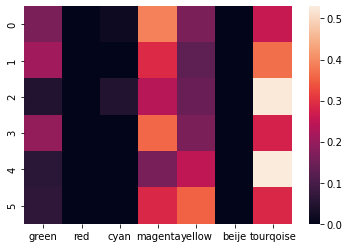

In [177]:
ax = sns.heatmap(heatmap_df)#, cmap="YlGnBu")

## get topic probability distribution for lowly expressed genes

In [145]:
p_tw_d_low = {'Topic 1':[],'Topic 2':[],'Topic 3':[],'Topic 4':[],'Topic 5':[],'Topic 6':[],'Topic 7':[]}

for i in range(len(corpus_low)):
    vector = model_lda[corpus_low[i]]
    for j in range(len(vector)):
        p_tw_d_low['Topic %s'%((j+1))].append(vector[j][1])


In [146]:
topic_dist_low = pd.DataFrame.from_dict(p_tw_d_low)
topic_dist_low.set_index(BoW_low.columns)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
Olfr1006,0.142683,0.142683,0.142683,0.143897,0.142684,0.142688,0.142683
Olfr1009,0.142683,0.142683,0.142683,0.143897,0.142684,0.142688,0.142683
Olfr1019,0.142682,0.142682,0.142682,0.143899,0.142684,0.142688,0.142682
Olfr102,0.143854,0.143571,0.142039,0.142930,0.142965,0.142383,0.142259
Olfr1020,0.142682,0.142682,0.142682,0.143899,0.142684,0.142688,0.142682
...,...,...,...,...,...,...,...
Olfr987,0.142683,0.142683,0.142683,0.143893,0.142685,0.142689,0.142683
Olfr988,0.142683,0.142683,0.142683,0.143893,0.142685,0.142689,0.142683
Olfr992,0.142683,0.142683,0.142683,0.143893,0.142685,0.142689,0.142683
Olfr994,0.142683,0.142683,0.142683,0.143894,0.142685,0.142689,0.142683


In [187]:
gene_to_topic_low = np.argmax(topic_dist_low.to_numpy(), axis = 1)
lda_labels_low = pd.DataFrame(gene_to_topic_low)
lda_labels_low = lda_labels_low.set_index(BoW_low.columns)

heatmap_low = np.zeros([no_topics,no_topics])
for item in lda_labels_low.index:
    if item in hsbm_labels.index:
    #print(item)
        heatmap_low[lda_labels_low.loc[item,:].values,hsbm_labels.loc[item,:].values[1]] += 1

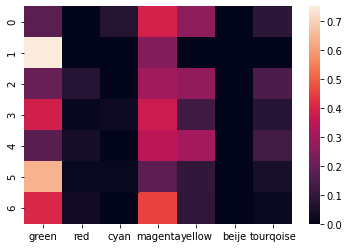

In [190]:
heatmap_low
heatmap_df = pd.DataFrame(heatmap_low, columns = ['green', 'red', 'cyan', 'magenta', 'yellow', 'beije','tourqoise'])
heatmap_df = heatmap_df.div(heatmap_df.sum(axis=1), axis=0)
ax = sns.heatmap(heatmap_df)

## Now fit supervised model via K-nearest neighbour

In [182]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from collections import OrderedDict

In [183]:
models = OrderedDict([
          ('Knn 5', KNeighborsClassifier(6)), #è il parametro più importante
          ('Logistic Regression', LogisticRegression()),
          ('Linear SVM', SVC(kernel='linear', probability=True))])

In [184]:
hsbm_high = hsbm_labels.loc[lda_labels.index.values,:]

In [185]:
X, y = topic_dist.T, hsbm_high.l1.values

In [186]:
#plt.figure(figsize=(5, 5))
scores = []
for name in models:
#for i in range(1):
    clf = models[name]

#plt.title(name)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    print(cross_val_score(clf, X, y, cv=5, scoring='accuracy'))
    

scores

C:\Users\Elisa\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Elisa\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Elisa\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Elisa\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C

[0.38043478 0.25       0.27777778 0.42222222 0.21348315]
[0.35869565 0.35869565 0.36666667 0.36666667 0.35955056]
[0.35869565 0.35869565 0.36666667 0.36666667 0.35955056]


[0.43859649122807015, 0.35964912280701755, 0.35964912280701755]

In [178]:
Z = clf.predict_proba(topic_dist_low)
Z.shape

(449, 5)

In [179]:
gene_to_topic_low = np.argmax(Z, axis = 1)
gene_to_topic_low

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

## Try with hsbm

In [89]:
import importlib, sbmtm_developer
from sbmtm_developer import sbmtm
model_hsbm = sbmtm()
model_hsbm_high = sbmtm()

model_hsbm.make_graph_from_BoW_df(BoW_low * 100)
model_hsbm_high.make_graph_from_BoW_df(BoW * 100)

In [90]:
model_hsbm_high.fit(B_min = 10, B_max = 50, n_init=5)

In [193]:
model_hsbm.fit(B_min = 10, B_max = 50, n_init=5)

In [85]:
model_hsbm_high.print_summary(tofile = False)#save_data()
V = model_hsbm_high.get_V()
D = model_hsbm_high.get_D()
N = model_hsbm_high.get_N()


state = model_hsbm_high.state
state_l = state.project_level(1).copy(overlap=True)
state_l_edges = state_l.get_ers#get_edge_blocks() ## labeled half-edges
B = state_l.B
E = state_l.get_E()
state_l.get_nonempty_B()
E

l: 0, N: 577, B: 50
l: 1, N: 50, B: 23
l: 2, N: 23, B: 11
l: 3, N: 11, B: 2
l: 4, N: 2, B: 1


3379

In [88]:
model_hsbm_high.get_groups()

AttributeError: 'BlockState' object has no attribute 'get_edge_blocks'

In [86]:
g = model_hsbm_high


        ## count labeled half-edges, group-memberships

n_wb = np.zeros((V,B)) ## number of half-edges incident on word-node w and labeled as word-group tw
n_db = np.zeros((D,B)) ## number of half-edges incident on document-node d and labeled as document-group td
n_dbw = np.zeros((D,B)) ## number of half-edges incident on document-node d and labeled as word-group tw

for e in g.edges():
    z1,z2 = state_l_edges[e]
    v1 = e.source()
    v2 = e.target()
    n_db[int(v1),z1] += 1
    n_dbw[int(v1),z2] += 1
    n_wb[int(v2)-D,z2] += 1

    p_w = np.sum(n_wb,axis=1)/float(np.sum(n_wb))

    ind_d = np.where(np.sum(n_db,axis=0)>0)[0]
    Bd = len(ind_d)
    n_db = n_db[:,ind_d] #selecting only the groups that are incident to at least one document

    ind_w = np.where(np.sum(n_wb,axis=0)>0)[0]
    Bw = len(ind_w)
    n_wb = n_wb[:,ind_w]

    ind_w2 = np.where(np.sum(n_dbw,axis=0)>0)[0]
    n_dbw = n_dbw[:,ind_w2]

        ## group-membership distributions
        # group membership of each word-node P(t_w | w)
    p_tw_w = (n_wb/np.sum(n_wb,axis=1)[:,np.newaxis]).T

        # group membership of each doc-node P(t_d | d)
    p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T

        ## topic-distribution for words P(w | t_w)
    p_w_tw = n_wb/np.sum(n_wb,axis=0)[np.newaxis,:]

        ## Mixture of word-groups into documents P(t_w | d)
    p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T
        
        ## topic-distribution for documents P(d | t_w)
    p_d_tw = (n_dbw/np.sum(n_dbw,axis=0)[np.newaxis,:])


    result = {}
    result['Bd'] = Bd
    result['Bw'] = Bw
    result['p_tw_w'] = p_tw_w
    result['p_td_d'] = p_td_d
    result['p_w_tw'] = p_w_tw
    result['p_tw_d'] = p_tw_d
    result['p_d_tw'] = p_d_tw


AttributeError: 'sbmtm' object has no attribute 'edges'

In [178]:
def get_normalized_clust_expression(clust, df, div, dim = 1):

    colors = ['b', 'g', 'r', 'c', 'm', 'y',  'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'yellow', 'yellowgreen','aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan']
    fig = plt.figure(figsize = (20,20))

    Normalized_data= {}
    group = 1


    for item in clust.columns:
    #print(clust_l2[item].values)
        not_null = (pd.isnull(clust.loc[:,item]).values)   
        genes = clust.loc[:,item].values
        
        
        
        #if (dim == 1):
        ax = fig.add_subplot(int(len(clust.columns)/div) + 1,div, group)
            
        #else:
            #ax = fig.add_subplot(int(len(clust.columns)/div) + 1,div, group, projection='3d') #fig.gca(projection='3d')#
        
        print(group)
        
        color = colors[group]        
        group += 1
        
        a = np.empty([len(df.index),1])
    
        for gene in (genes[~not_null]):
      
            X_train = df[gene].values
            X_train = X_train.reshape(len(df.index),1)            
            X_fitted = min_max_scaler.fit_transform(X_train)
            
        
           # Normalized_data['cluster'].append(item)     
            #Normalized_data[gene] = X_fitted
            a = np.hstack((a,X_fitted))
            
            #if group == 7:
             #   print(X_fitted)
                
            if (dim == 1):
             
                ax.plot((X_fitted), alpha = 0.1, color = color) 
                ax.set_xlabel("DV position")
                ax.set_ylabel("normalized_expr")   
                ax.set_title(item)#, fontsize = 20)
            
            else:
                
                z = X_fitted.reshape(len(df.index),)
               # ax.plot(coord_DV,coord_PA,z, alpha = 0.05, c = color)

                ax.set_xlabel('Dorsal-Ventral')#, fontsize = 20)
                ax.set_ylabel('Posterior - Anterior')#, fontsize = 20)
                #ax.set_zlabel('Normalized Expression')#, fontsize = 20)
                ax.set_title(item,  fontsize = 15)
                
        
        a = a[:,1:]
        average = np.mean(a, axis = 1)
        stdv = np.std(a, axis = 1)
        #print(item,average,stdv)
        
        if (dim == 1):
            ax.plot(average, color='black', linewidth = 2, linestyle='dashed')
            ax.fill_between(np.arange(len(df.index)), average+stdv, average-stdv, facecolor=color, alpha=0.4)
            
        else:
            #average = average.reshape(72,82)
            
            X = np.array(coord_DV)
            Y = np.array(coord_PA)
            #X,Y = np.meshgrid(Y,X)
            plt.scatter(X, Y, alpha=0.5, c = average, cmap=cm.coolwarm)
            plt.colorbar()
            #surf = ax.plot_trisurf(coord_DV,coord_PA, average,cmap=cm.coolwarm, linewidth=0, antialiased=False) #color='black', linewidth = 2, linestyle='dashed')
            #ax.zaxis.set_major_locator(LinearLocator(10))
            #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

            # Add a color bar which maps values to colors.
            #fig.colorbar(surf, shrink=0.5, aspect=5)
            
                       
            #plt.show() 
            
           # Normalized_data['expr'].append(list(min_max_scaler.fit_transform(X_train)))
    
    return fig

1
2
3
4
5
6
7


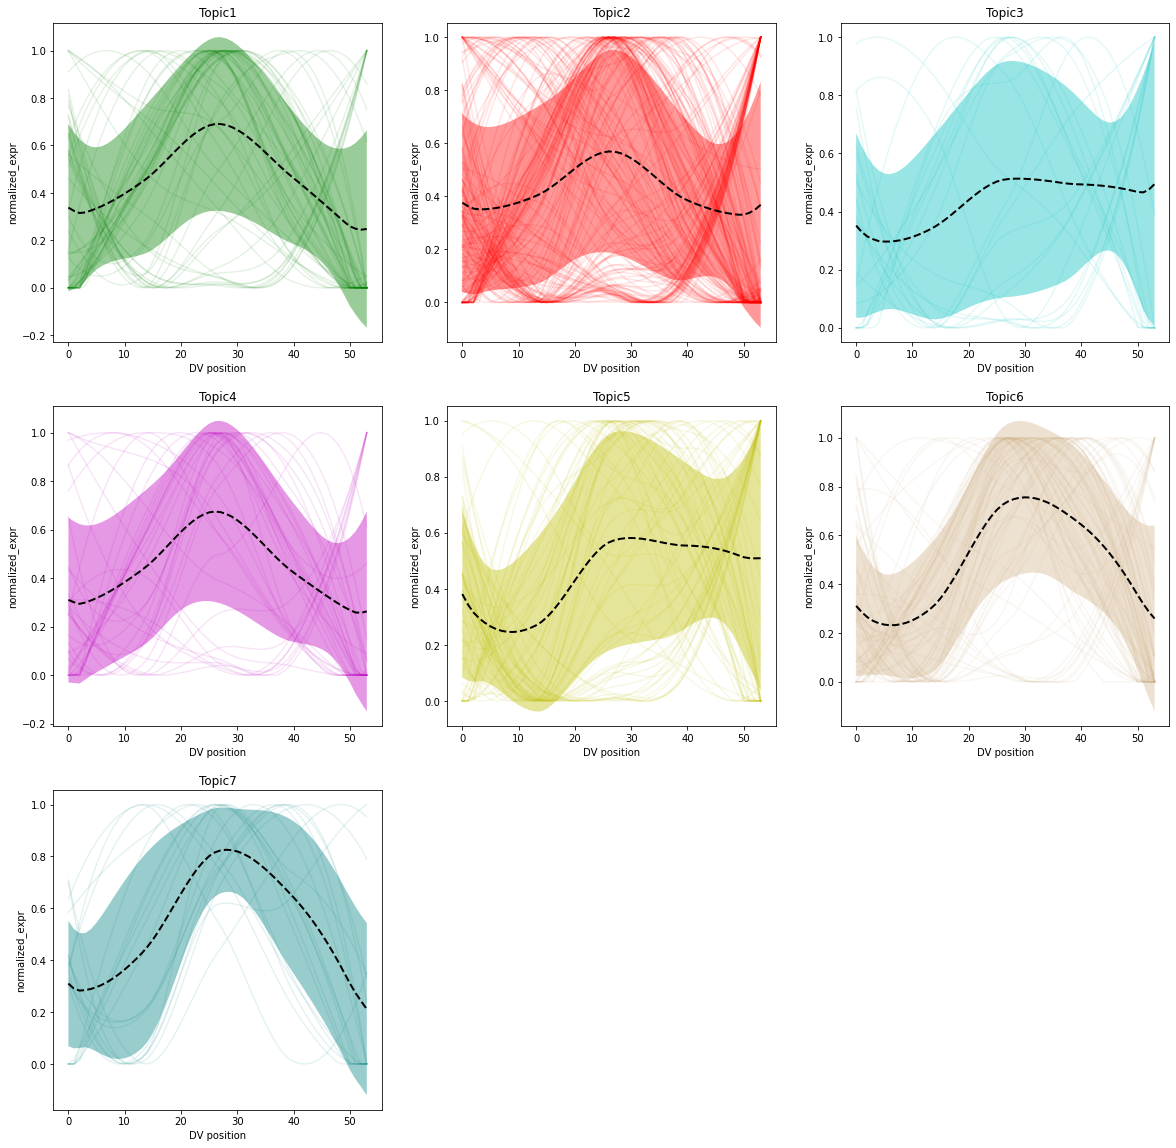

In [181]:
fig = get_normalized_clust_expression(clust_lda.T, df.loc[:,features_highly.index],3, dim = 1)

In [162]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_training, corpus, dictionary)

C:\Users\Elisa\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [163]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.039566 -0.003847       1        1  14.358589
0      0.007036 -0.011460       2        1  14.356936
3     -0.003240  0.031490       3        1  14.305587
5     -0.006000 -0.001121       4        1  14.263066
6     -0.021360 -0.014551       5        1  14.247195
1     -0.010484 -0.002926       6        1  14.241421
2     -0.005518  0.002415       7        1  14.227205, topic_info=    Category       Freq           Term      Total  loglift  logprob
63   Default   8.000000  OR-Cluster-25   8.000000  30.0000  30.0000
114  Default   5.000000      Sfaktiria   5.000000  29.0000  29.0000
74   Default   5.000000  OR-Cluster-35   5.000000  28.0000  28.0000
109  Default  11.000000            Rho  11.000000  27.0000  27.0000
78   Default   9.000000  OR-Cluster-39   9.000000  26.0000  26.0000
..       ...        ...            ...        ...      ...      ...
133   Topic7   7.263372      crowded_2  83.020485  -0.4862  -4.0437
125   Topic7   3.965998            XXL  29.101606  -0.0430  -4.6488
64    Topic7   4.462310  OR-Cluster-26  39.612877  -0.2335  -4.5309
115   Topic7   4.094339        Sikinos  37.003677  -0.2514  -4.6169
129   Topic7   2.843793            X_4  36.969761  -0.6149  -4.9814

[338 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         6  0.934426          1
1         1  0.113506         10
1         2  0.113506         10
1         3  0.113506         10
1         4  0.113506         10
...     ...       ...        ...
136       3  0.164705  crowded_5
136       4  0.131764  crowded_5
136       5  0.115294  crowded_5
136       6  0.098823  crowded_5
136       7  0.148235  crowded_5

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 7, 2, 3])